In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [46]:

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("text-classification2")

2023/03/08 11:59:19 INFO mlflow.tracking.fluent: Experiment with name 'text-classification2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/projects/mlops-demos/experiment-tracking/mlruns/3', creation_time=1678269559591, experiment_id='3', last_update_time=1678269559591, lifecycle_stage='active', name='text-classification2', tags={}>

In [12]:
#Load Data
import pandas as pd
df_train = pd.read_csv('https://raw.githubusercontent.com/hamed-abdelhaq/spark-demos/master/data/deep-learning-datasets/twitter-sentiment-analysis/train_E6oV3lV.csv')
df_train.columns = ["id", "label", "text"]

df_test = pd.read_csv('https://raw.githubusercontent.com/hamed-abdelhaq/spark-demos/master/data/deep-learning-datasets/twitter-sentiment-analysis/test_tweets_anuFYb8.csv')
df_test.columns = ["id","text"]
df_train

,id,label,text
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [52]:
from sklearn.model_selection import train_test_split

X = df_train.text.values
y = df_train.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [16]:
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):

    s = s.lower()
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # separate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])





In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):

    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [ ]:
# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [63]:

for alpha in np.arange(1, 2, 0.2):
    for ngram in [2,3]:
        for max_df in np.arange(1000, 10000, 1000):
            with mlflow.start_run():
                tf_idf = TfidfVectorizer(ngram_range=(1, ngram),
                                    binary=True,
                                    smooth_idf=False,
                                    max_df = max_df)
                X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
                X_val_tfidf = tf_idf.transform(X_val_preprocessed)

                mlflow.set_tag("developer", "hamed")
                # Compute predicted probabilities
                mlflow.log_param("alpha", alpha)
                mlflow.log_param("ngram", ngram)
                mlflow.log_param("max_df", max_df)

                print(alpha, ngram, max_df)

                nb_model = MultinomialNB(alpha=alpha)
                nb_model.fit(X_train_tfidf, y_train)
                probs = nb_model.predict_proba(X_val_tfidf)

                # Evaluate the classifier
                auc, accuracy = evaluate_roc(probs, y_val)
                mlflow.log_metric("auc", auc)
                mlflow.log_metric("accuracy", accuracy)

1.0 2 1000
1.0 2 2000
1.0 2 3000
1.0 2 4000
1.0 2 5000
1.0 2 6000
1.0 2 7000
1.0 2 8000
1.0 2 9000
1.0 3 1000
1.0 3 2000
1.0 3 3000
1.0 3 4000
1.0 3 5000
1.0 3 6000
1.0 3 7000
1.0 3 8000
1.0 3 9000
1.2 2 1000
1.2 2 2000
1.2 2 3000
1.2 2 4000
1.2 2 5000
1.2 2 6000
1.2 2 7000
1.2 2 8000
1.2 2 9000
1.2 3 1000
1.2 3 2000
1.2 3 3000
1.2 3 4000
1.2 3 5000
1.2 3 6000
1.2 3 7000
1.2 3 8000
1.2 3 9000
1.4 2 1000
1.4 2 2000
1.4 2 3000
1.4 2 4000
1.4 2 5000
1.4 2 6000
1.4 2 7000
1.4 2 8000
1.4 2 9000
1.4 3 1000
1.4 3 2000
1.4 3 3000
1.4 3 4000
1.4 3 5000
1.4 3 6000
1.4 3 7000
1.4 3 8000
1.4 3 9000
1.5999999999999999 2 1000
1.5999999999999999 2 2000
1.5999999999999999 2 3000
1.5999999999999999 2 4000
1.5999999999999999 2 5000
1.5999999999999999 2 6000
1.5999999999999999 2 7000
1.5999999999999999 2 8000
1.5999999999999999 2 9000
1.5999999999999999 3 1000
1.5999999999999999 3 2000
1.5999999999999999 3 3000
1.5999999999999999 3 4000
1.5999999999999999 3 5000
1.5999999999999999 3 6000
1.59999999999999

Best alpha:  1.0


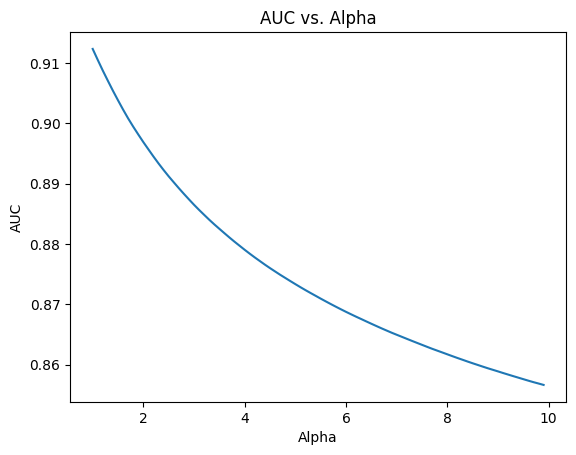

In [29]:
from sklearn.naive_bayes import MultinomialNB

sub_res = [get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(1, 10, 0.1)]
res = pd.Series(sub_res, index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [58]:
from sklearn.metrics import accuracy_score, roc_curve
from sklearn import metrics

def evaluate_roc(probs, y_true1):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true1, preds)
    roc_auc = metrics.auc(fpr, tpr)
    #print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true1, y_pred)
    #print(f'Accuracy: {accuracy*100:.2f}%')
    
    return roc_auc, accuracy
    # # Plot ROC AUC
    # plt.title('Receiver Operating Characteristic')
    # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

In [41]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "hamed")
    # Compute predicted probabilities
    alpha = 3
    mlflow.log_param("alpha", alpha)

    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_tfidf, y_train)
    probs = nb_model.predict_proba(X_val_tfidf)

    # Evaluate the classifier
    auc, accuracy = evaluate_roc(probs, y_val)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("accuracy", accuracy)

In [64]:
import pickle

In [67]:
import pickle
# model tracking by maintaining artifacts
with mlflow.start_run():
    
    mlflow.set_tag("developer", "hamed")
    # Compute predicted probabilities
    alpha = 3
    mlflow.log_param("alpha", alpha)

    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_tfidf, y_train)

    pickle.dump(nb_model, open('models/model.pkl', 'wb'))

    mlflow.log_artifact(local_path='models/model.pkl', artifact_path='models_pickles')

    probs = nb_model.predict_proba(X_val_tfidf)

    # Evaluate the classifier
    auc, accuracy = evaluate_roc(probs, y_val)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("accuracy", accuracy)

In [71]:
import pickle
# # model tracking by logging model data and metadata
with mlflow.start_run():
    
    mlflow.set_tag("developer", "hamed")
    # Compute predicted probabilities
    alpha = 3
    mlflow.log_param("alpha", alpha)

    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_tfidf, y_train)

    pickle.dump(nb_model, open('models/model.pkl', 'wb'))

    mlflow.sklearn.log_model(nb_model, 'models_pickles')

    probs = nb_model.predict_proba(X_val_tfidf)

    # Evaluate the classifier
    auc, accuracy = evaluate_roc(probs, y_val)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("accuracy", accuracy)

In [74]:

logged_model = 'runs:/248549b6bfe24e10bc8c82d8a703704b/models_pickles'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model
# # Predict on a Pandas DataFrame.
# import pandas as pd
# loaded_model.predict((X_val_tfidf))

mlflow.pyfunc.loaded_model:
  artifact_path: models_pickles
  flavor: mlflow.sklearn
  run_id: 248549b6bfe24e10bc8c82d8a703704b